/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:74: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1, 256, 256, 1) (1, 256, 256, 1)
0.4000857
(3, 256, 256)


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:66: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


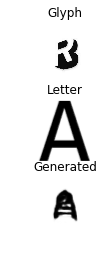

success!


In [6]:
#调用图片处理相关库
from __future__ import print_function, division
import scipy
#from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from numpy import random
#调用keras库
from keras.models import load_model


class glyph2glyph():
   #初始化
    def __init__(self,  img_res=(256, 256)):
        self.img_res = img_res
        # Input shape
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        #创建images文件夹
        if not os.path.exists("images"):
            os.makedirs('images')
        
        #载入generator模型
        self.generator = load_model('model/G_ChefGAN.hdf5')  #‘生成模型地址’
        
        #载入rebuilder模型
        self.rebuilder = load_model('model/Gr_ChefGAN.hdf5')  #‘还原模型地址’
        
        #载入discriminator模型作为评分器
        self.discriminator = load_model('model/D_ChefGAN.hdf5') #‘判别模型地址’
        

    
    #主功能模块
    def go_generate (self, logo_path, base_path):
        #导入图片
        img_logo = self.imread(logo_path)    #作为风格的标志图形
        img_base = self.imread(base_path)  #作为基础字形的字母
        print(img_logo.shape, img_base.shape)
        
        
        #生成字体
        gen_font = self.generator.predict([img_logo,img_base]) #获得一个shape为[1,256,256,1]
        
        #对生成的字体打分
        valid = self.discriminator.predict([img_logo,img_base,gen_font]) #获得的是一个评分矩阵
        score = np.mean(np.abs(valid)) #计算评分矩阵的均值作为最终分数
        print(score)
        
        #如果生成字体分数太低就进行循环生成
        while score < 0.3:
            cyc_logo = gen_font
            gen_font = self.generator.predict([cyc_logo,img_base]) #循环生成就是用gen_font作为logo来进行二次生成
            valid = self.discriminator.predict([cyc_logo,img_base,gen_font]) #获得的是一个评分矩阵
            score = np.mean(np.abs(valid))  #计算评分矩阵的均值作为最终分数
            print(score)
            
        #保存图片
        img_font = np.squeeze(gen_font)  #把值为1维度去掉，[1,256,256,1] --> [256,256] 
        scipy.misc.imsave('images/output.png', img_font)
        
        #保存对比图 标志+字形+生成字体
        self.save_image(img_logo, img_base, gen_font)
    
        
    def imread(self, path):
        img = scipy.misc.imread(path, mode='L').astype(np.float)  #以灰度模式L打开图片
        img = scipy.misc.imresize(img, self.img_res)  #RESIZE图片到256*256
        img = np.expand_dims(img, axis=2) #添加通道维
        imgs = []
        imgs.append(img) #添加Batch维度
        imgs = np.array(imgs)/127.5 - 1. #归一化
        return imgs
             
    
        
    def save_image(self, img_logo, img_base, gen_font):
        r, c = 3, 1 

        gen_imgs = np.squeeze(np.concatenate([img_logo, img_base, gen_font]))

        # 重整图片到0-1
        gen_imgs = 0.5 * gen_imgs + 0.5
        print(gen_imgs.shape)

        titles = ['Glyph', 'Letter', 'Generated']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            #for j in range(c):
            axs[i].imshow(gen_imgs[cnt], cmap='gray')
            axs[i].set_title(titles[i])
            axs[i].axis('off')
            cnt += 1
        fig.savefig("images/gen_img.png" )
        plt.show()
        #plt.close()
        print("success!")
        
        
if __name__ == '__main__':
    gogen = glyph2glyph()
    gogen.go_generate(logo_path='./datasets/timg2.jpeg', base_path = './abc/A.png')
        